# Miconi network

Reward-modulated recurrent network based on:

> Miconi T. (2017). Biologically plausible learning in recurrent neural networks reproduces neural dynamics observed during cognitive tasks. eLife 6:e20899. doi:10.7554/eLife.20899

In [ ]:
!pip install ANNarchy

In [1]:
from ANNarchy import *
clear()
setup(dt=1.0)

ANNarchy 4.7 (4.7.1.5) on darwin (posix).


![](img/miconi.png)

Each neuron in the reservoir follows the following equations:

$$
    \tau \frac{dx(t)}{dt} + x(t) = \sum_\text{input} W^\text{IN} \, r^\text{IN}(t) + \sum_\text{rec} W^\text{REC} \, r(t) + \xi(t)
$$

$$
    r(t) = \tanh(x(t))
$$

where $\xi(t)$ is a random perturbation at 3 Hz, with an amplitude randomly sampled between $-A$ and $+A$.

We additionally keep track of the mean firing rate with a sliding average:

$$
    \tilde{x}(t) = \alpha \, \tilde{x}(t) + (1 - \alpha) \, x(t)
$$

Some neurons keep a constant rate throughout learning (1 or -1) to provide some bias to the other neurons.

In [2]:
neuron = Neuron(
    parameters = """
        tau = 30.0 : population # Time constant
        constant = 0.0 # The four first neurons have constant rates
        alpha = 0.05 : population # To compute the sliding mean
        f = 3.0 : population # Frequency of the perturbation
        A = 16. : population # Perturbation amplitude. dt*A/tau should be 0.5...
    """,
    equations="""
        # Perturbation
        perturbation = if Uniform(0.0, 1.0) < f/1000.: 1.0 else: 0.0 
        noise = if perturbation > 0.5: A*Uniform(-1.0, 1.0) else: 0.0

        # ODE for x
        x += dt*(sum(in) + sum(exc) - x + noise)/tau

        # Output r
        rprev = r
        r = if constant == 0.0: tanh(x) else: tanh(constant)

        # Sliding mean
        delta_x = x - x_mean
        x_mean = alpha * x_mean + (1 - alpha) * x
    """
)

The learning rule is defined by a trace $e_{i, j}(t)$ for each synapse $i \rightarrow j$ incremented at each time step with:

$$
    e_{i, j}(t) = e_{i, j}(t-1) + (r_i (t) \, x_j(t))^3
$$

At the end $T$ of a trial, a normalized reward $(R -R_\text{mean})$ is delivered and all weights are updated using:

$$
    \Delta w_{i, j} = - \eta \,  e_{i, j}(T) \, (R -R_\text{mean})
$$

All traces are then reset to 0 for the next trial. Weight changes are clamped between -0.0003 and 0.0003.

As ANNarchy applies the synaptic equations at each time step, we need to introduce a boolean `learning_phase` which performs trace integration when 0, weight update when 1.

In [3]:
synapse = Synapse(
    parameters="""
        eta = 0.5 : projection # Learning rate
        learning_phase = 0.0 : projection # Flag to allow learning only at the end of a trial
        error = 0.0 : projection # Reward received
        mean_error = 0.0 : projection # Mean Reward received
        max_weight_change = 0.0003 : projection # Clip the weight changes
    """,
    equations="""
        # Trace
        trace += if learning_phase < 0.5:
                    power(pre.rprev * (post.delta_x), 3)
                 else:
                    0.0

        # Weight update only at the end of the trial
        delta_w = if learning_phase > 0.5:
                eta * trace * (mean_error) * (error - mean_error)
             else:
                 0.0 : min=-max_weight_change, max=max_weight_change
        w -= if learning_phase > 0.5:
                delta_w
             else:
                 0.0
    """
)

We model the DNMS task of Miconi. The RC network has two inputs A and B. The reservoir has 200 neurons, 3 of which have constant rates. 

In [4]:
# Input population
inp = Population(2, Neuron(parameters="r=0.0"))

# Recurrent population
N = 200
pop = Population(N, neuron)
pop[1].constant = 1.0
pop[10].constant = 1.0
pop[11].constant = -1.0
pop.x = Uniform(-0.1, 0.1)

Input weights are uniformly distributes between -1 and 1.

Recurrent weights and normally distributed, with a coupling strength of $g=1.5$ (edge of chaos).

Connections are all-to-all (fully connected).

In [5]:
# Input weights
Wi = Projection(inp, pop, 'in')
Wi.connect_all_to_all(weights=Uniform(-1.0, 1.0))

# Recurrent weights
g = 1.5
Wrec = Projection(pop, pop, 'exc', synapse)
Wrec.connect_all_to_all(weights=Normal(0., g/np.sqrt(N)), allow_self_connections=True)

In [6]:
compile()

Compiling ...  OK 


The output of the reservoir is chosen to be the neuron of index 100.

In [7]:
output_neuron = 100

We record the rates inside the reservoir:

In [8]:
m = Monitor(pop, ['r'])

Parameters defining the task:

In [9]:
# Compute the mean reward per trial
R_mean = np.zeros((2, 2))
alpha = 0.75 # 0.33

# Durations
d_stim = 200
d_delay= 200
d_response = 400
d_execution= 200

Definition of a DNMS trial (AA, AB, BA, BB):

In [10]:
def dnms_trial(trial, first, second, R_mean):
    traces = []

    # Reinitialize network
    pop.x = Uniform(-0.1, 0.1).get_values(N)
    pop.r = np.tanh(pop.x)
    pop[1].r = np.tanh(1.0)
    pop[10].r = np.tanh(1.0)
    pop[11].r = np.tanh(-1.0)

    # First input
    inp[first].r = 1.0
    simulate(d_stim)
    
    # Delay
    inp.r = 0.0
    simulate(d_delay)
    
    # Second input
    inp[second].r = 1.0
    simulate(d_stim)
    
    # Relaxation
    inp.r = 0.0
    simulate(d_response)
    
    # Read the output
    rec = m.get()
    
    # Compute the target
    target = 0.98 if first != second else -0.98
    
    # Response is over the last 200 ms
    output = rec['r'][-int(d_execution):, output_neuron] # neuron 100 over the last 200 ms
    
    # Compute the error
    error = np.mean(np.abs(target - output))
    print('Target:', target, '\tOutput:', "%0.3f" % np.mean(output), '\tError:',  "%0.3f" % error, '\tMean:', "%0.3f" % R_mean[first, second])
    
    # The first 25 trial do not learn, to let R_mean get realistic values
    if trial > 25:
        # Apply the learning rule
        Wrec.learning_phase = 1.0
        Wrec.error = error
        Wrec.mean_error = R_mean[first, second]
        # Learn for one step
        step()
        # Reset the traces
        Wrec.learning_phase = 0.0
        Wrec.trace = 0.0
        _ = m.get() # to flush the recording of the last step

    # Update the mean reward
    R_mean[first, second] = alpha * R_mean[first, second] + (1.- alpha) * error

    return rec, traces, R_mean

In [ ]:
# Initial weights
init_w = Wrec.w

# Many trials of each type
try:
    for trial in range(2500):
        print('Trial', trial)
        recordsAA, tracesAA, R_mean = dnms_trial (trial, 0, 0, R_mean)
        recordsAB, tracesAB, R_mean = dnms_trial (trial, 0, 1, R_mean)
        recordsBA, tracesBA, R_mean = dnms_trial (trial, 1, 0, R_mean)
        recordsBB, tracesBB, R_mean = dnms_trial (trial, 1, 1, R_mean)
        if trial == 0:
            initialAA = recordsAA['r']
            initialAB = recordsAB['r']
            initialBA = recordsBA['r']
            initialBB = recordsBB['r']
except KeyboardInterrupt:
    pass

# Final weights
final_w = Wrec.w

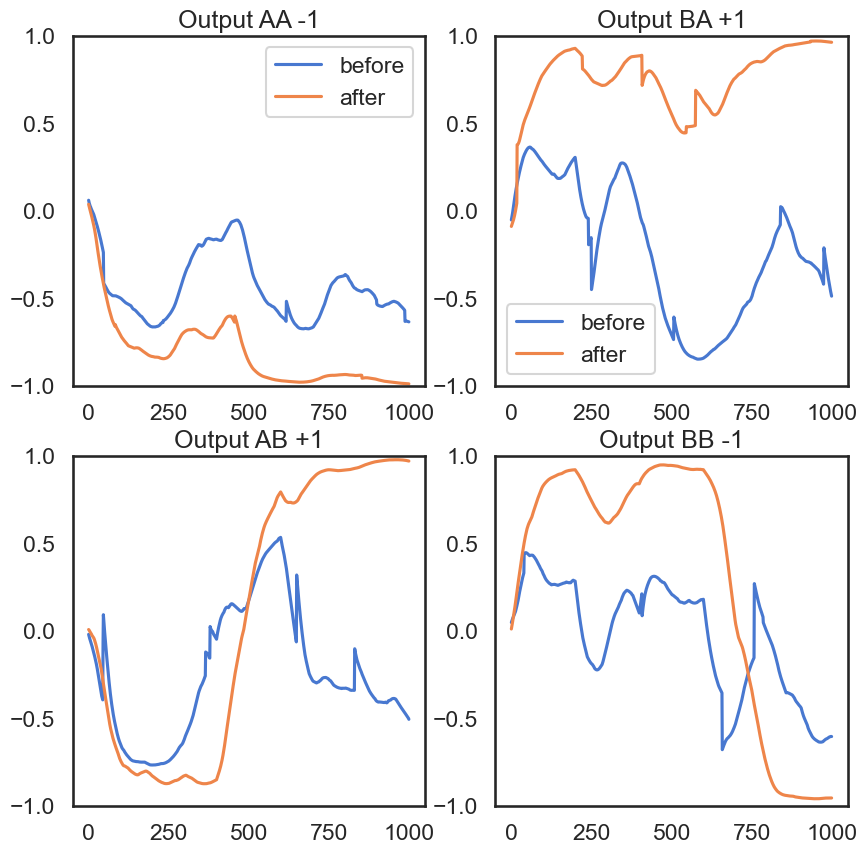

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
sns.set_context("talk")

plt.figure(figsize=(10, 10))

ax = plt.subplot(221)
ax.plot(np.mean(initialAA[:, output_neuron:output_neuron+1], axis=1), label='before')
ax.plot(np.mean(recordsAA['r'][:, output_neuron:output_neuron+1], axis=1), label='after')
ax.set_ylim((-1., 1.))
ax.legend()
ax.set_title('Output AA -1')
ax = plt.subplot(222)
ax.plot(np.mean(initialBA[:, output_neuron:output_neuron+1], axis=1), label='before')
ax.plot(np.mean(recordsBA['r'][:, output_neuron:output_neuron+1], axis=1), label='after')
ax.set_ylim((-1., 1.))
ax.legend()
ax.set_title('Output BA +1')
ax = plt.subplot(223)
ax.plot(np.mean(initialAB[:, output_neuron:output_neuron+1], axis=1), label='before')
ax.plot(np.mean(recordsAB['r'][:, output_neuron:output_neuron+1], axis=1), label='after')
ax.set_ylim((-1., 1.))
ax.set_title('Output AB +1')
ax = plt.subplot(224)
ax.plot(np.mean(initialBB[:, output_neuron:output_neuron+1], axis=1), label='before')
ax.plot(np.mean(recordsBB['r'][:, output_neuron:output_neuron+1], axis=1), label='after')
ax.set_ylim((-1., 1.))
ax.set_title('Output BB -1')
plt.show()
